In [333]:
import pandas as pd
import numpy as np
import joblib
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from missforest import MissForest
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
import lightgbm as lgb
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

In [334]:
df = pd.read_csv("/workspaces/carlossuesc95-intro-ml/data/raw/internal-link tree.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [335]:
df_cop = df.copy()
vars_cero = ['Insulin', 'BloodPressure', 'BMI', 'Glucose']
df_cop[vars_cero] = df_cop[vars_cero].replace(0, np.nan)

### Train Test Split

In [336]:
X = df_cop.drop('Outcome',axis=1)
y = df_cop['Outcome']

In [337]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Imputación

In [338]:
imputer = MissForest()

X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)
X_train_imp

/home/vscode/.local/lib/python3.11/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:02<00:00,  2.33it/s]
/home/vscode/.local/lib/python3.11/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/home/vscode/.local/lib/python3.11/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 88.73it/s]
/home/vscode/.local/lib/python3.11/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themse

,Pregnancies,SkinThickness,DiabetesPedigreeFunction,Age,Glucose,BMI,BloodPressure,Insulin
60,2,0,0.304,21,84.0,28.242551,69.845022,111.183151
618,9,24,1.282,50,112.0,28.200000,82.000000,169.580819
346,1,19,0.654,22,139.0,28.700000,46.000000,83.000000
294,0,0,0.254,65,161.0,21.900000,50.000000,240.720132
231,6,37,0.238,46,134.0,46.200000,80.000000,370.000000
...,...,...,...,...,...,...,...,...
71,5,35,0.411,26,139.0,28.600000,64.000000,140.000000
106,1,0,0.207,27,96.0,22.400000,122.000000,98.703986
270,10,37,1.136,38,101.0,45.600000,86.000000,119.074207
435,0,0,0.205,29,141.0,42.400000,73.711028,117.731710


## Sel Caracteristicas

In [339]:
# Modelo Random Forest
model = RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1).fit(X_train_imp,y_train)
# Importancia de características
importances = model.feature_importances_/model.feature_importances_.sum()*100

#Convertir a dataframe
df_rf_imp = pd.DataFrame({'feature': X_train.columns,'rf_importance': importances}).sort_values(by='rf_importance', ascending=False)

#importancia acumulada
df_rf_imp['rf_importance_accum'] = df_rf_imp['rf_importance'].cumsum()

df_rf_imp

,feature,rf_importance,rf_importance_accum
4,Insulin,22.417130,22.417130
7,Age,15.934207,38.351338
5,BMI,15.176889,53.528226
3,SkinThickness,13.508448,67.036674
2,BloodPressure,11.027584,78.064258
6,DiabetesPedigreeFunction,7.783808,85.848066
0,Pregnancies,7.263399,93.111465
1,Glucose,6.888535,100.000000


In [340]:
##XGBClassifier

#crear conjunto de val
X_train1, X_val, y_train1, y_val = train_test_split(X_train_imp,y_train, test_size=0.2,random_state=42)

#ajustar modelo

model_xgb = XGBClassifier(objective='binary:logistic',random_state=42).fit(X_train1,y_train1)

#### 10 permutaciones por caracteristica

In [341]:
perm = permutation_importance(model_xgb,X_val,y_val,n_repeats=10,random_state=42,n_jobs=-1,scoring='recall')
df_perm_imp = pd.DataFrame({'feature': X_train.columns, 'perm_imp': perm.importances_mean*100}).sort_values('perm_imp', ascending=False)
df_perm_imp

,feature,perm_imp
4,Insulin,16.666667
5,BMI,5.000000
3,SkinThickness,4.761905
0,Pregnancies,3.095238
1,Glucose,2.380952
7,Age,1.904762
2,BloodPressure,1.190476
6,DiabetesPedigreeFunction,0.476190


In [342]:
#HistGradientBoostingClassifier
model_hgb = HistGradientBoostingClassifier(random_state=42).fit(X_train1,y_train1)
df_perm_hgb = permutation_importance(model_hgb,X_val,y_val,n_repeats=10,random_state=42,n_jobs=-1,scoring='recall')
df_hgb_imp = pd.DataFrame({'feature': X_train.columns, 'hgb_imp': df_perm_hgb.importances_mean*100}).sort_values('hgb_imp', ascending=False)
df_hgb_imp

,feature,hgb_imp
4,Insulin,15.714286
3,SkinThickness,9.523810
5,BMI,6.190476
2,BloodPressure,3.809524
7,Age,2.142857
1,Glucose,0.238095
0,Pregnancies,-3.571429
6,DiabetesPedigreeFunction,-4.285714


In [343]:
df_importances = (
    df_rf_imp
    .merge(df_perm_imp, on='feature', how='outer')
    .merge(df_hgb_imp, on='feature', how='outer')
).sort_values('rf_importance', ascending=False)
df_importances

,feature,rf_importance,rf_importance_accum,perm_imp,hgb_imp
5,Insulin,22.417130,22.417130,16.666667,15.714286
0,Age,15.934207,38.351338,1.904762,2.142857
1,BMI,15.176889,53.528226,5.000000,6.190476
7,SkinThickness,13.508448,67.036674,4.761905,9.523810
2,BloodPressure,11.027584,78.064258,1.190476,3.809524
3,DiabetesPedigreeFunction,7.783808,85.848066,0.476190,-4.285714
6,Pregnancies,7.263399,93.111465,3.095238,-3.571429
4,Glucose,6.888535,100.000000,2.380952,0.238095


In [344]:
df_filt = df_importances[(df_importances['rf_importance']>=1)&(df_importances['perm_imp']>=1)&(df_importances['hgb_imp']>=1)]
df_filt

,feature,rf_importance,rf_importance_accum,perm_imp,hgb_imp
5,Insulin,22.417130,22.417130,16.666667,15.714286
0,Age,15.934207,38.351338,1.904762,2.142857
1,BMI,15.176889,53.528226,5.000000,6.190476
7,SkinThickness,13.508448,67.036674,4.761905,9.523810
2,BloodPressure,11.027584,78.064258,1.190476,3.809524


In [345]:
features = df_filt['feature']
features

5          Insulin
0              Age
1              BMI
7    SkinThickness
2    BloodPressure
Name: feature, dtype: object

In [346]:
# Modelo con features seleccionadas
X_train_sel = X_train_imp[features]
X_test_sel = X_test_imp[features]

### modelo XGBClassifier

In [347]:

model_boosted_1 = XGBClassifier(
    n_estimators=5,
    max_depth=5, 
    learning_rate=0.3, 
    objective='binary:logistic',
    random_state=42,
    min_samples_leaf=8,)
model_boosted_1.fit(X_train_sel,y_train)
# make predictions 
test_pred = model_boosted_1.predict(X_test_sel)

/home/vscode/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [18:07:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "min_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [348]:
accuracy_score(y_test,test_pred)

0.7077922077922078

### modelo HistGradientBoostingClassifier

In [349]:
model_hgb = HistGradientBoostingClassifier(
    random_state=42, 
    max_iter=20,
    learning_rate=0.1,
    max_depth=4,
    min_samples_leaf=20)
model_hgb.fit(X_train_sel,y_train)
# make predictions
test_pred_1= model_hgb.predict(X_test_sel)

In [350]:
accuracy_score(y_test,test_pred_1)

0.7207792207792207

## matriz del modelo seleccionado 

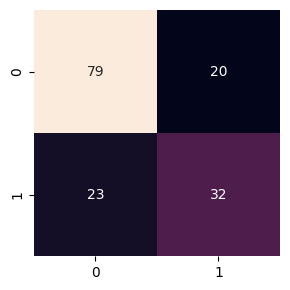

              precision    recall  f1-score   support

           0       0.77      0.80      0.79        99
           1       0.62      0.58      0.60        55

    accuracy                           0.72       154
   macro avg       0.69      0.69      0.69       154
weighted avg       0.72      0.72      0.72       154



In [351]:

matriz_cm = confusion_matrix(y_test, test_pred_1)
cm_df = pd.DataFrame(matriz_cm)
plt.figure(figsize = (3, 3))
sns.heatmap(cm_df, annot=True, fmt="d", cbar=False)
plt.tight_layout()
plt.show() 
print(classification_report(y_test, test_pred_1))

#### Podemos observar en la matriz del modelo seleccionado un 72% de accuracy lo que significa una capacidad notable, pero no tan fiable de predecir correctamente los casos de diabletes usando este modelo. Se podrai usar otro modelo o mejorar el que se esta usando.
#### En el caso de Diabletes negativa (0), el porcentaje de acierto es un poco mejor 77% ,teniendo en cuenta que el recall es de 80% ,detecta mejor los casos de falsos negativo. 